In [1]:
from gensim.models import fasttext
from gensim.models import FastText
import pandas as pd
pd.options.mode.copy_on_write = True
import numpy as np
from nltk.tokenize import RegexpTokenizer
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud

origin_train = './train_data/'
origin_test = './test_data/'

In [2]:
corpus = pd.read_csv(origin_train + 'corpus.csv')
corpus

,quechua
0,Quchakuna: Kivu qucha
1,Runakunaqa uywakunapas ñawinkunawanmi rikun. R...
2,Commons nisqaqa multimidya kapuyninkunayuqmi k...
3,NaN
4,Commons nisqaqa multimidya kapuyninkunayuqmi k...
...,...
178960,"Ellos son hechiceros, ch'eqmiseros228, brujos229."
178961,6 ñiqin hatun puquy killapi 337 watapimanta 12...
178962,Kuyuylla karu rimanapaq rikuriy
178963,Haki distritu (kastilla simipi: Distrito de Ja...


In [3]:
sufixes = pd.read_csv(origin_train + 'sufixes.csv')
sufixes

,sufix
0,cha
1,chaw
2,chi
3,chka
4,chra
...,...
69,yoq
70,ysi
71,yuq
72,ña


## Preprocesamiento

In [4]:
def remove_sufixes(word, sufixes):
    for suffix in sufixes:
        if word.endswith(suffix):
            return word[:-len(suffix)]
    return word

def remove_empty_strings_rows(df, column):
    return df[df[column].str.strip().astype(bool)]

def remove_invalid_word(word):
    # Check if the word contains any digits
    if re.search(r'\d', word):
        return ''
    
    # Check if the word contains only allowed characters (a-z, ñ, apostrophes, and spaces)
    if not re.match(r"^[a-zñA-ZÑ' ]*$", word):
        return ''
    
    # Check if the word contains any of the unwanted characters: b, d, e, f, g, j, o, v, x, z
    if re.search(r"[bdefgjovxzBDEFGJOVXZ]", word):
        return ''
    
    return word

def clean_df(cad):
    text = cad.lower()
    text = " ".join(text.split())
    text = text.replace('´', "'")
    
    tokenizer = RegexpTokenizer(r"[a-zA-Z0-9']+(?:\w*)")
    text = tokenizer.tokenize(text)
    words = [remove_sufixes(word, sufixes['sufix']) for word in text]
    words = [remove_invalid_word(word) for word in words]
    result = " ".join(words)
    result = ' '.join(result.split())
    return result.split()

In [5]:
# Cleaning the corpus
corpus = remove_empty_strings_rows(corpus, 'quechua')
corpus.dropna(inplace=True)

# Applying the cleaning function and filtering empty lists
corpus['quechua'] = corpus['quechua'].apply(clean_df)
corpus = corpus[corpus['quechua'].apply(lambda x: len(x) > 0)]

# Filtering words shorter than 3 characters
corpus['quechua'] = corpus['quechua'].apply(lambda words_list: [word for word in words_list if len(word) >= 3])

# Check for empty rows after all operations
corpus = corpus[corpus['quechua'].apply(lambda x: len(x) > 0)]

# Reset index if needed
corpus.reset_index(drop=True, inplace=True)

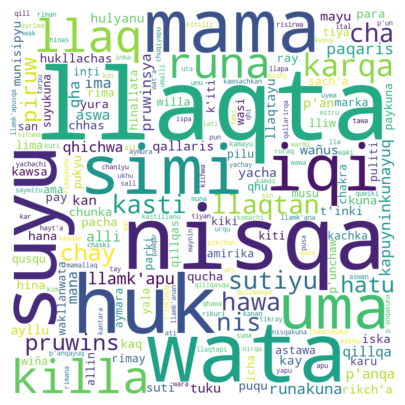

In [6]:
# Assuming 'corpus' is a DataFrame with a column 'quechua' containing lists of words
word_counts = {}
for words in corpus['quechua']:
    for word in words:
        if word in word_counts:
            word_counts[word] += 1
        else:
            word_counts[word] = 1

# Generate WordCloud based on frequencies
wordcloud = WordCloud(width=800, height=800, background_color="white").generate_from_frequencies(word_counts)

# Plotting the WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [7]:
len(word_counts)

67741

In [ ]:
!curl -o ./train_data/cc.qu.300.bin.gz https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.qu.300.bin.gz
!tar -xvf ./train_data/cc.qu.300.bin.gz

## Modelo preentrenado (300 dimensiones)

- Puede dar problemas por su alta dimensionalidad respecto a la cantidad de datos

In [ ]:
modelFT = fasttext.load_facebook_model(origin_train+'cc.qu.300.bin')
modelFT.build_vocab(corpus['quechua'], update=True)
modelFT.train(corpus['quechua'], total_examples=modelFT.corpus_count, epochs=15)

## Modelo entrenado solo con corpus (50 dimensiones)

In [ ]:
modelFT = FastText(corpus['quechua'], vector_size=50, window=5, min_count=20, workers=20, sg=1,epochs=10)
modelFT.build_vocab(corpus['quechua'])
modelFT.train(corpus['quechua'], total_examples=modelFT.corpus_count, epochs=modelFT.epochs)

In [ ]:
modelFT.save(origin_train+'fasttext.model')

In [10]:

modelFT = FastText.load(origin_train+'fasttext.model')

In [11]:
modelFT.wv.most_similar_to_given('wayra',['runa','pisqu','suyo'])

'pisqu'